In [6]:
import sklearn
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from tensorflow import keras
import tensorflow as tf
import pickle
import os
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_pickle("./data.pkl")

In [8]:
target_names = ["titel", "bouwjaar", "kilometer_stand", "vermogen", "is_handgeschakeld", "is_benzine", "upload_datum", "apk"]

numeric_features = ['bouwjaar', "kilometer_stand", "vermogen", "upload_datum", "apk"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('text',  CountVectorizer(), 'titel')],
    remainder='passthrough')

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]['prijs']
X_test

,titel,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,upload_datum,apk
357,fiat punto grande active deurs rijklaarprijs k...,2009,141940.0,67,1.0,1,16,147
851,fiat grande punto dynamic,2007,179086.0,65,1.0,1,10,163
780,fiat grande punto dynamic goed onderhouden,2006,160886.0,65,1.0,1,2,147
268,fiat grande punto actual airco deurs,2010,185314.0,84,1.0,0,25,600
41,fiat grande punto active,2007,232477.0,75,1.0,0,13,297
...,...,...,...,...,...,...,...,...
817,fiat grande punto dynamic airco clima cruise c...,2008,65513.0,77,1.0,1,5,57
26,fiat grande punto edizione cool deurs garantie,2006,117271.0,67,1.0,1,12,147
92,fiat grande punto dynamic airco cruise auto,2008,172488.0,77,1.0,1,18,169
11,fiat grande punto active,2007,238443.0,75,1.0,0,11,147


In [10]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Epoch 1/500
23/23 [==============================] - 0s 12ms/step - loss: 18736096.0000 - mae: 3682.8862 - mse: 18736096.0000 - val_loss: 20362292.0000 - val_mae: 3820.6833 - val_mse: 20362292.0000
Epoch 2/500
23/23 [==============================] - 0s 2ms/step - loss: 18621452.0000 - mae: 3668.9009 - mse: 18621452.0000 - val_loss: 20132594.0000 - val_mae: 3793.4937 - val_mse: 20132594.0000
Epoch 3/500
23/23 [==============================] - 0s 2ms/step - loss: 18262806.0000 - mae: 3623.4563 - mse: 18262806.0000 - val_loss: 19477058.0000 - val_mae: 3716.2073 - val_mse: 19477058.0000
Epoch 4/500
23/23 [==============================] - 0s 2ms/step - loss: 17381878.0000 - mae: 3511.5437 - mse: 17381878.0000 - val_loss: 18076334.0000 - val_mae: 3545.6233 - val_mse: 18076334.0000
Epoch 5/500
23/23 [==============================] - 0s 2ms/step - loss: 15711448.0000 - mae: 3288.6519 - mse: 15711448.0000 - val_loss: 15680926.0000 - val_mae: 3234.8059 - val_mse: 15680926.0000
Epoch 6/500
23

(0.0, 99.0)

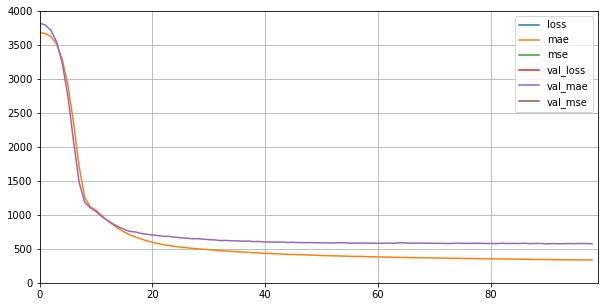

In [14]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape=X_train.shape[1:]),
#     keras.layers.Dense(200, activation="relu"),
#     keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(
    loss="mean_squared_error", 
    optimizer=optimizer, 
    metrics=['mae', 'mse']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

history = model.fit(
    X_train, 
    y_train.values, 
    batch_size=32, 
    epochs=500, 
    validation_data=(X_test, y_test.values),
    verbose=1,
    callbacks=[callback]
)

mse_test = model.evaluate(X_test, y_test.values)

pd.DataFrame(history.history).plot(figsize=(10, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 4000) 
plt.gca().set_xlim(0, len(history.history['loss'])) 

In [5]:
model_version = "0001"
model_name = "TFAuto"
model_path = os.path.join(model_name) 
model.save(model_path)
scaler_path = os.path.join(model_name, 'TFScaler.pkl') 
joblib.dump(scaler, scaler_path) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: TFAuto\assets


['TFAuto\\TFScaler.pkl']